## Final Presentation Code -- Szmurlo

In [105]:

import lucem_illud 


import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import copy
import re
import networkx as nx
import sklearn


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

import scipy

import os #For looking through files
import os.path #For managing file paths

Import pandas dataframe of previously cleaned letter data

In [59]:
letters= pandas.read_pickle('C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018-new\\letters1.pkl')

In [60]:
letters.head()

,company,text,year,good
118,3m,dear shareholder:\n\nthanks to the hard work o...,2000,1
120,americanexpress,"cardmembers, a reflection of our successful ef...",2000,1
121,at&t,the transformation of at&t\n\nthree years ago ...,2000,1
122,boeing,here is our plan for growing the boeing compan...,2000,1
123,caterpillar,"”plan. are in place to acmieve $30 illllon\n""i...",2000,1


Select letters longer than 300 words

In [61]:
letters['length'] = 0
for index, row in letters.iterrows():
    letters.loc[index,'length'] = len(row.text.split())
letters=letters[letters.length>300]

Describe letter lengths

In [62]:
letters.length.describe()

count      430.000000
mean      2410.511628
std       2724.958582
min        316.000000
25%       1080.000000
50%       1705.000000
75%       2573.500000
max      24815.000000
Name: length, dtype: float64

Describe letters before and after 2008

In [63]:
lettersb = letters[letters.year<2008]
lettersb.length.describe()

count      193.000000
mean      2285.388601
std       1631.618572
min        492.000000
25%       1291.000000
50%       1737.000000
75%       2684.000000
max      10462.000000
Name: length, dtype: float64

In [64]:
lettersa=letters[letters.year>=2008]
lettersa.length.describe()

count      237.000000
mean      2512.405063
std       3362.855252
min        316.000000
25%        935.000000
50%       1654.000000
75%       2554.000000
max      24815.000000
Name: length, dtype: float64

Companies before and after 2008:

In [65]:
before = list(set(lettersb.company))
print('Before 2008:')
print(before)
print(len(before))
after = list(set(lettersa.company))
print('After 2008:')
print(after)
print(len(after))

Before 2008:
['pfizer', 'ciscosystem', 'homedepot', 'hp', 'americanexpress', 'unitedhealth', 'international paper company letter', 'cocacola', 'chevron', 'mcdonalds', 'goldmansachs', 'generalelectric', 'exxonmobil', 'travelers', 'citigroup', 'nike', 'dupont', 'ibm', 'walmart', 'caterpillar', 'intel', 'eastman kodak letter', 'verizon', 'johnsonjohnson', 'microsoft', 'at&t', '3m', 'disney', 'jpmorganchase', 'p&g', 'boeing', 'merck', 'unitedtechnologies']
33
After 2008:
['pfizer', 'homedepot', 'ciscosystem', 'americanexpress', 'unitedhealth', 'cocacola', 'chevron', 'mcdonalds', 'goldmansachs', 'generalelectric', 'exxonmobil', 'travelers', 'visa', 'nike', 'citigroup', 'dupont', 'alcoa', 'ibm', 'walmart', 'caterpillar', 'intel', 'bankofamerica', 'verizon', 'microsoft', 'johnsonjohnson', 'at&t', 'disney', '3m', 'jpmorganchase', 'p&g', 'boeing', 'merck', 'unitedtechnologies']
33


## Linguistic Change

In [66]:
#remove stop words while preserving sentence structure
letters['tokenized_sents'] = letters['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
letters['normalized_sents'] = letters['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

letters[:5]

,company,text,year,good,length,tokenized_sents,normalized_sents
118,3m,dear shareholder:\n\nthanks to the hard work o...,2000,1,1319,"[[dear, shareholder, :, thanks, to, the, hard,...","[[dear, shareholder, thanks, hard, work, oftho..."
120,americanexpress,"cardmembers, a reflection of our successful ef...",2000,1,509,"[[cardmembers, ,, a, reflection, of, our, succ...","[[cardmembers, reflection, successful, efforts..."
121,at&t,the transformation of at&t\n\nthree years ago ...,2000,1,1359,"[[the, transformation, of, at, &, t, three, ye...","[[transformation, three, years, ago, clear, te..."
122,boeing,here is our plan for growing the boeing compan...,2000,1,2194,"[[here, is, our, plan, for, growing, the, boei...","[[plan, growing, boeing, covers, three, period..."
123,caterpillar,"”plan. are in place to acmieve $30 illllon\n""i...",2000,1,834,"[[”, plan, .], [are, in, place, to, acmieve, $...","[[plan], [place, acmieve, illllon, revenue], [..."


In [67]:
lettersa=letters[letters.year>=2008]
lettersb=letters[letters.year<2008]

In [68]:
#modeling and visualization written by TAs
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [69]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [70]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            v1 = embeddingsDict[cat][0][word]
            v2 = embed[word]
            cs = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(v1, axis = 0),np.expand_dims(v2, axis =0))
            #dists[cat].append(np.abs(math.pow(2.718,(1 - cs[0,0]))))
            dists[cat].append(np.abs(1 - cs[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [71]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        v1 = embeddingsDict[cats[0]][0][word]
        v2 = embed[word]
        
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(v1, axis = 0),np.expand_dims(v2, axis =0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [72]:
#reduce # of companies in the dataset to interesting companies
lettersClean = letters[letters.company!='alcoa']
lettersClean = lettersClean[lettersClean.year>=2000]
lettersClean = lettersClean[lettersClean.company!='']
lettersClean = lettersClean[lettersClean.company!='merck']
lettersClean = lettersClean[lettersClean.company!='hp']
lettersClean = lettersClean[lettersClean.company!='dupont']
lettersClean = lettersClean[lettersClean.company!='visa']
lettersClean = lettersClean[lettersClean.company!='bankofamerica']
lettersClean = lettersClean[lettersClean.company!='eastman kodak letter']
lettersClean = lettersClean[lettersClean.company!='ibm']
lettersClean = lettersClean[lettersClean.company!='verizon']
lettersClean = lettersClean[lettersClean.company!='citigroup']
lettersClean = lettersClean[lettersClean.company!='pfizer']
lettersClean = lettersClean[lettersClean.company!='intel']
lettersClean = lettersClean[lettersClean.company!='exxonmobil']
lettersClean = lettersClean[lettersClean.company!='microsoft']
lettersClean = lettersClean[lettersClean.company!='3m']
lettersClean = lettersClean[lettersClean.company!='unitedtechnologies']
lettersClean = lettersClean[lettersClean.company!='p&g']
lettersClean = lettersClean[lettersClean.company!='unitedhealth']
lettersClean = lettersClean[lettersClean.company!='nike']
lettersClean = lettersClean[lettersClean.company!='at&t']
lettersClean = lettersClean[lettersClean.company!='international paper company letter']
lettersClean = lettersClean[lettersClean.company!='walmart']
lettersClean = lettersClean[lettersClean.company!='eastman kodak']
lettersClean = lettersClean[lettersClean.company!='international paper company']
lettersClean = lettersClean[lettersClean.company!='unitedtechnologie']

rawEmbeddings, comparedEmbeddings = compareModels(lettersClean, 'company')
print(sorted(list(set(lettersClean.company))))

['americanexpress', 'boeing', 'caterpillar', 'chevron', 'ciscosystem', 'cocacola', 'disney', 'generalelectric', 'goldmansachs', 'homedepot', 'johnsonjohnson', 'jpmorganchase', 'mcdonalds', 'travelers']


In [73]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 90 words to compare


In [74]:
#most divergent
wordDivergences[:10]

[('top', 1.3646714687347412),
 ('throughout', 1.3376375436782837),
 ('end', 1.2328245043754578),
 ('next', 1.1619343161582947),
 ('take', 1.1285066306591034),
 ('corporate', 0.9528332948684692),
 ('competitive', 0.9527802467346191),
 ('continuing', 0.94077467918396),
 ('working', 0.9289721846580505),
 ('expect', 0.9071362018585205)]

In [75]:
#least divergent
wordDivergences[-10:]

[('million', 0.18294483423233032),
 ('performance', 0.16290408372879028),
 ('also', 0.15878081321716309),
 ('company', 0.1457226276397705),
 ('value', 0.14408379793167114),
 ('year', 0.13915735483169556),
 ('us', 0.12566399574279785),
 ('new', 0.10893917083740234),
 ('growth', 0.09576189517974854),
 ('business', 0.0899345874786377)]

Produce Visualizations

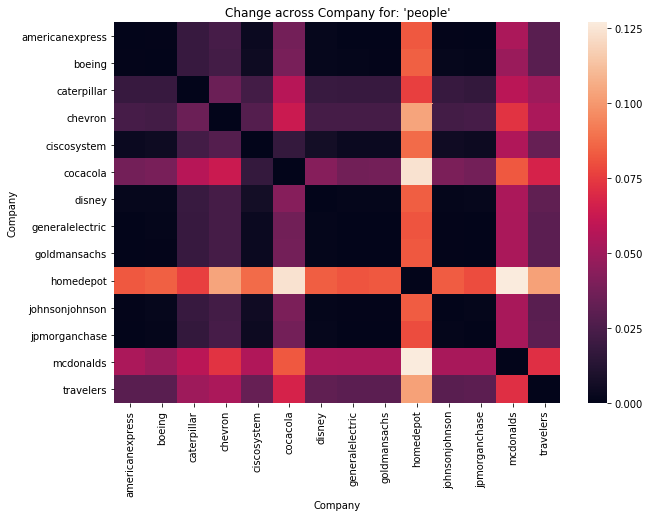

In [76]:
targetWord = 'people'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Company")
ax.set_ylabel("Company")
ax.set_ylabel("Company")
ax.set_title("Change across Company for: '{}'".format(targetWord))
plt.show()

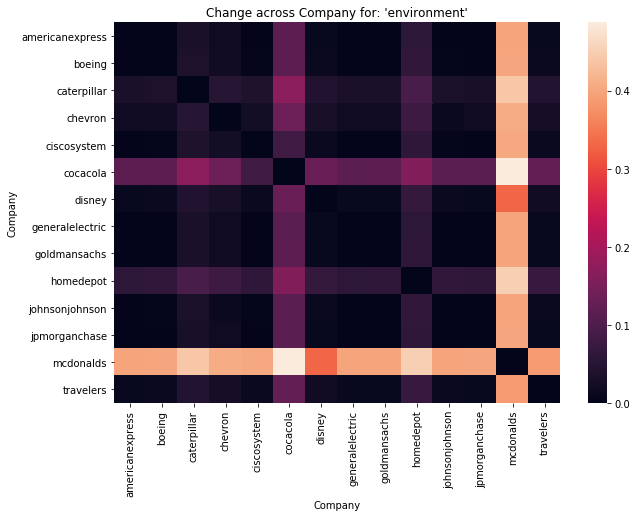

In [77]:
targetWord = 'environment'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Company")
ax.set_ylabel("Company")
ax.set_ylabel("Company")
ax.set_title("Change across Company for: '{}'".format(targetWord))
plt.show()

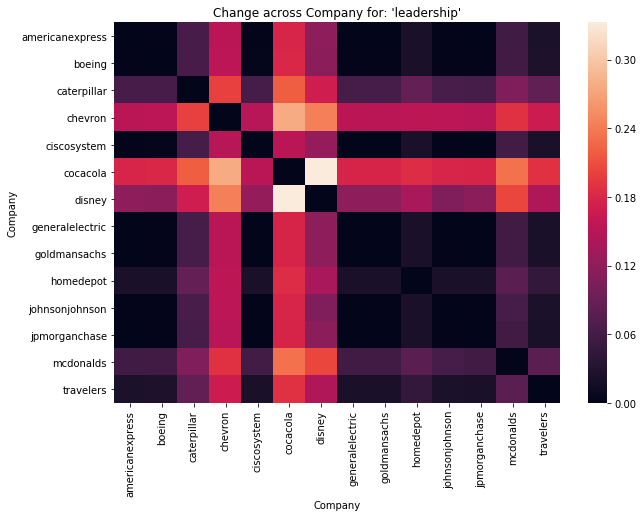

In [78]:
targetWord = 'leadership'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Company")
ax.set_ylabel("Company")
ax.set_ylabel("Company")
ax.set_title("Change across Company for: '{}'".format(targetWord))
plt.show()

## 2008 Event Study

Linguistic Change across time:

In [79]:
rawEmbeddings, comparedEmbeddings = compareModels(letters[letters.year>=2000], 'year')

In [80]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 164 words to compare


In [81]:
#most divergent
wordDivergences[:10]

[('includes', 2.0088141560554504),
 ('mobile', 1.7307514697313309),
 ('level', 1.6981183588504791),
 ('helping', 1.6292677372694016),
 ('impact', 1.5320661962032318),
 ('fiscal', 1.4041792452335358),
 ('communities', 1.3311975449323654),
 ('changes', 1.1531979590654373),
 ('manufacturing', 1.1046331822872162),
 ('report', 1.1008983552455902)]

In [82]:
#least divergent
wordDivergences[-10:]

[('strong', 0.4493620991706848),
 ('make', 0.4392077922821045),
 ('customers', 0.43536847829818726),
 ('sales', 0.4266338348388672),
 ('new', 0.42218679189682007),
 ('growth', 0.41658586263656616),
 ('value', 0.4036486744880676),
 ('use', 0.4017453193664551),
 ('best', 0.4003058671951294),
 ('care', 0.40012162923812866)]

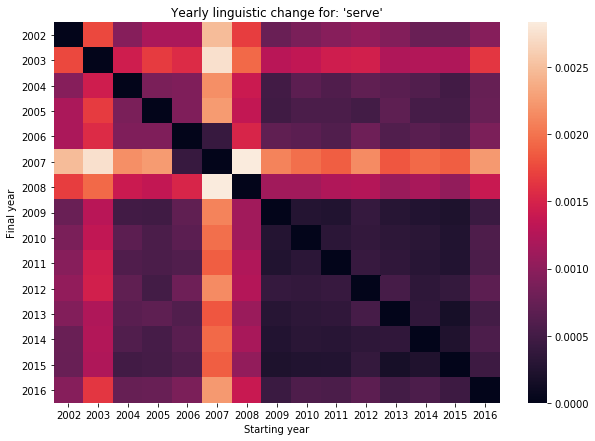

In [83]:
targetWord = 'serve'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
reducedDF = pltDF[list(range(2002, 2017))].copy()
reducedDF = reducedDF.drop(2017)
reducedDF = reducedDF.drop(2000)
reducedDF = reducedDF.drop(2001)

fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(reducedDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

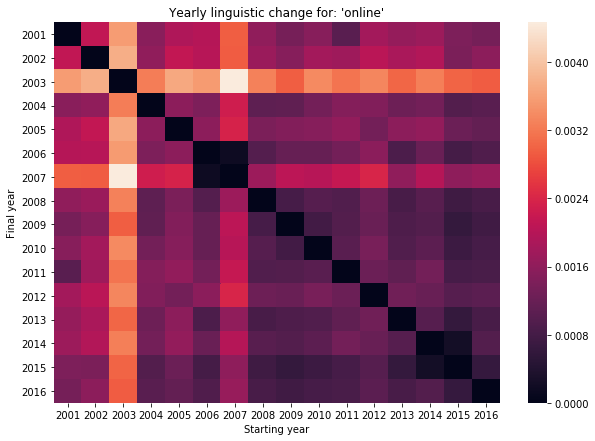

In [84]:
targetWord = 'online'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
reducedDF = pltDF[list(range(2001, 2017))].copy()
reducedDF = reducedDF.drop(2017)
reducedDF = reducedDF.drop(2000)

fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(reducedDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

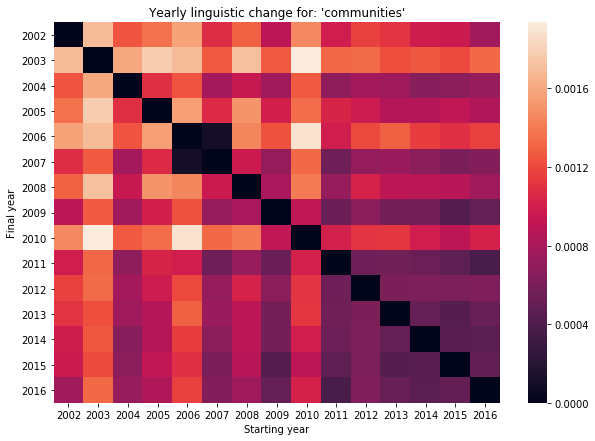

In [85]:
targetWord = 'communities'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
reducedDF = pltDF[list(range(2002, 2017))].copy()
reducedDF = reducedDF.drop(2017)
reducedDF = reducedDF.drop(2000)
reducedDF = reducedDF.drop(2001)

fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(reducedDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

Visualize contexts for the word 'diversity' before and after 2008:

In [139]:
nbeforeT = nltk.word_tokenize(lettersb.text.sum())
nafterT=nltk.word_tokenize(lettersa.text.sum())

In [140]:
nTextB = nltk.Text(nbeforeT)
nTextA = nltk.Text(nafterT)

In [141]:
nIndexB = nltk.text.ConcordanceIndex(nTextB)
nIndexA = nltk.text.ConcordanceIndex(nTextA)
nIndexA.print_concordance('diversity')

Displaying 25 of 58 matches:
onal strength . Clearly , 3M ’ s diversity continues to provide us some ins
on against economic cycles . Our diversity may not shield us as effectively
ase and the full power of 3M ’ s diversity will be evident once again . 3M 
spects . We bene˜t from both the diversity of our payments businesses and o
fer a Our size , scale , revenue diversity and ability to execute are never
emonstrates why we value revenue diversity so highly in our business model 
we™ve built this company is that diversity creates strength . Diversity of 
nd services . We have geographic diversity . with 53 % of our revenues outs
tical to driving growth . Global diversity is important in this cycle becau
the company , we seek to promote diversity at every level and in everything
rms , and geographic reach . The diversity of our business portfolio create
es to invest in innovation . The diversity of P & G ’ s brand portfolio giv
share ideas openly and encourage diversity of experience an

In [142]:
nIndexB.print_concordance('diversity')

Displaying 25 of 68 matches:
0. our unique product and global diversity gave us the strength tn post sol
ere we operate , and promot— ing diversity and opportunity in our work forc
e twirl engines ofinnovation and diversity . wc ‘ vc begun to redeﬁne ourse
 system . lcadcrship on managing diversity and protecting the environment w
urrency impacts . the geographic diversity of our company contributed great
 others however . because of our diversity we 've never had a truly early-c
ucial because of the breadth and diversity of our health care businesses . 
a work environment that embraces diversity , sparks innovation and encourag
ur end-to-end architecture ; the diversity of customers we serve around the
up brings together an incredible diversity of products and services , . , m
es , not earnings . Our business diversity , initiatives , financial streng
s . We use our resources and our diversity to create value for investors . 
, together with the strength and diversity of our businesse

Generate list of mosts distinguishing words betweeen letters before and after 2008 (using KL divergence):

In [91]:
#Apply tokenization functions
lettersa['tokenized_text'] = lettersa['text'].apply(lambda x: nltk.word_tokenize(x))
lettersa['normalized_tokens'] = lettersa['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))

lettersb['tokenized_text'] = lettersb['text'].apply(lambda x: nltk.word_tokenize(x))
lettersb['normalized_tokens'] = lettersb['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))


c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [92]:
nBWords = set(lettersb['normalized_tokens'].sum())
nAWords = set(lettersa['normalized_tokens'].sum())

In [95]:
overlapWords = nBWords & nAWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [97]:
#count occurances & create arrays
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

nBProbArray = makeProbsArray(lettersb['normalized_tokens'], overlapWordsDict)
nAProbArray = makeProbsArray(lettersa['normalized_tokens'], overlapWordsDict)
nBProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

In [100]:
nABDivergence = scipy.stats.entropy(nAProbArray, nBProbArray)
print (nABDivergence)
nBADivergence = scipy.stats.entropy(nBProbArray, nAProbArray)
print (nBADivergence)

0.13047648023038189
0.11588707638172967


In [104]:
nABDivergence_ew = scipy.special.kl_div(nAProbArray, nBProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = nABDivergence_ew
kl_df.sort_values(by='elementwise divergence', ascending=False)[:30]


,word,elementwise divergence
2687,œ,0.010517
2360,cloud,0.003832
2468,š,0.002029
1543,regul,0.001755
4646,ł,0.001565
6306,basel,0.001565
1709,bank,0.001505
2285,crisi,0.001438
399,visa,0.001091
6051,analyt,0.001035


## JPMorgan Chase

Note: networks are slightly different from those in the presentation due to slight differences in the dataset

In [106]:
#Looking only at the JPMorgan Chase Letters -- abnormally long for an annual report letter
letters['chase'] = 0

In [107]:
def chase(str):
    if 'chase' in str.lower():
        return 1
    else: return 0
letters.chase = letters.company.apply(lambda x: chase(x))
chase=letters[letters['chase']==1]
chase['sentences'] = chase['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
chase.index = range(len(chase) - 1, -1,-1) #Reindex to make things nice in the future
chase[:3]

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,company,text,year,good,length,tokenized_sents,normalized_sents,chase,sentences
15,jpmorganchase,to our shareholders\n\n“ Even though we are go...,2001,1,2431,"[[to, our, shareholders, “, Even, though, we, ...","[[shareholders, even, though, going, one, diff...",1,"[[to, our, shareholders, “, Even, though, we, ..."
14,jpmorganchase,To our shareholders\n\n \n\n2002 was a year of...,2002,1,2072,"[[To, our, shareholders, 2002, was, a, year, o...","[[shareholders, year, many, challenges], [fina...",1,"[[To, our, shareholders, 2002, was, a, year, o..."
13,jpmorganchase,Dear fellow shareholders\n\nThe announced JP. ...,2003,1,2684,"[[Dear, fellow, shareholders, The, announced, ...","[[dear, fellow, shareholders, announced, jp], ...",1,"[[Dear, fellow, shareholders, The, announced, ..."


Generating interesting networks:

In [108]:
chase['normalized_sents'] = chase['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [109]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

Create Nouns network:

In [110]:
#NN
gNN = posCooccurrence(chase['normalized_sents'].sum(), 'NN')

In [111]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 4365
Number of edges: 137619
Average degree:  63.0557


In [112]:
#remove verticies with low degrees
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 600]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 56
Number of edges: 1581
Average degree:  56.4643


In [113]:
#remove edges with low weight
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 56
Number of edges: 1481
Average degree:  52.8929


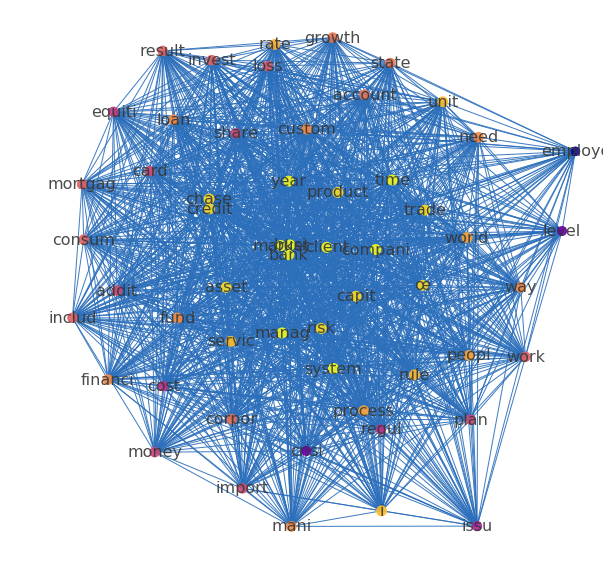

In [114]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

Generate Noun-Verb Network:

In [115]:
gNV = posCooccurrence(chase['normalized_sents'].sum(), 'NN', 'VB')

In [116]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 4765
Number of edges: 182450
Average degree:  76.5792


In [117]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [118]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 4765
Number of edges: 47646
Average degree:  19.9983


In [119]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 8])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 8])

In [120]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 66
Number of edges: 526
Average degree:  15.9394


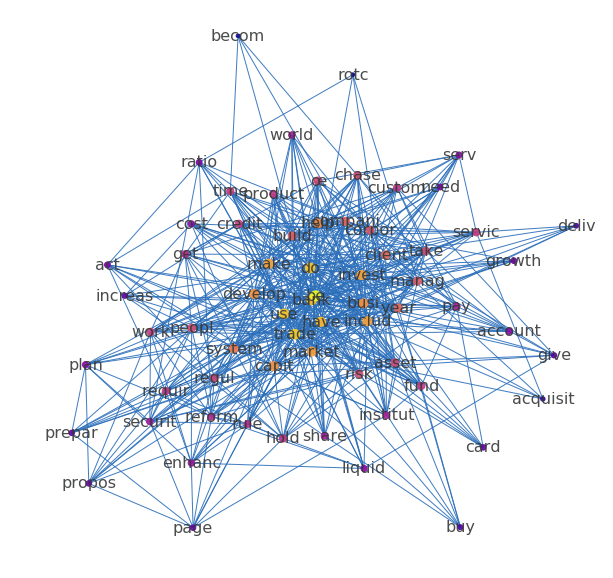

In [121]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Generate ego network around 'client' using noun-verb network

In [123]:
g_i = gNV.subgraph(['client'] + list(gNV.neighbors('client')))

In [124]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 21
Number of edges: 20
Average degree:   1.9048


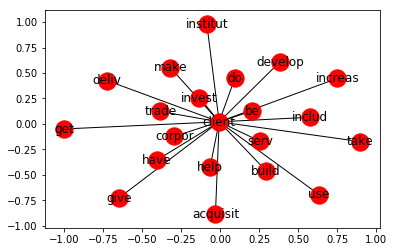

In [125]:
nx.draw_networkx(g_i)

Import pre-tagged letters (using Stanford tags in week 7):

In [126]:
let = pandas.read_pickle('C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018-new\\lettersPOSNER.pkl')

Clean data and select chase letters

In [127]:
for index, row in let.iterrows():
    a = row.company
    a =a.replace('letter',"")
    a=a.strip(' ')
    a=a.strip("'s")
    a=a.strip("'")
    if 'walmart' in a.lower():
        a = 'Walmart'
    if 'home' in a.lower():
        a= 'HomeDepot'
    if 'disney' in a.lower():
        a= 'Disney'
    if 'exxon' in a.lower():
        a = 'ExxonMobil'
    if 'johnson' in a.lower():
        a= 'JohnsonJohnson'
    if '3m' in a.lower():
        a = '3m'
    if 'citi' in a.lower():
        a = 'citigroup'
    if 'chevron' in a.lower():
        a = 'chevron'
    if 'p&g' in a.lower():
        a= 'p&g'
    if 'procter' in a.lower():
        a= 'p&g'
    if 'proctor' in a.lower():
        a = 'p&g'
    if 'boeing' in a.lower():
        a= 'boeing'
    if 'hp' in a.lower():
        a = 'hp'      
    if 'hewlett' in a.lower():
        a = 'hp'
    if 'morgan' in a.lower():
        a = 'JPMorganChase'
    if 'technologies' in a.lower():
        a= 'UnitedTechnologies'
    if 'ge' in a.lower():
        a = 'GeneralElectric'
    if 'electric' in a.lower():
        a= 'GeneralElectric'
    if 'traveler' in a.lower():
        a = 'travelers'
    if 'alcoa' in a.lower():
        a = 'Alcoa'
    if 'microsoft' in a.lower():
        a = 'microsoft'
    if 'intel' in a.lower():
        a= 'Intel'
    if 'pfizer' in a.lower():
        a = 'pfizer'
    if 'caterpillar' in a.lower():
        a = 'caterpillar'
    if 'ibm' in a.lower():
        a = 'ibm'
    if 'merck' in a.lower():
        a = 'merck'
    if 'verizon' in a.lower():
        a = 'verizon'
    if 'depot' in a.lower():
        a= 'HomeDepot'
    if 'gold' in a.lower():
        a = 'GoldmanSachs'
    if 'dupont' in a.lower():
        a = 'dupont'
    if 'bank of america' in a.lower():
        a = 'bankofamerica'
    if 'health' in a.lower():
        a = 'UnitedHealth'
    a =re.sub('letter','',a)
    if 'disney letter' ==a.lower():
        a = 'disney'
    if 'jp morgan and chase letter' ==a.lower():
        a = 'JPMorganChase'
    if 'home depot' == a.lower():
        a = 'homedepot'
    if '3m letter' == a.lower():
        a= '3m'
    if 'dupont letter' == a.lower():
        a = 'dupont'
    if 'verizon communications letter' ==a.lower():
        a = 'verizon'
    if 'mcdonalds letter' == a.lower():
        a = 'mcdonalds'

    if 'the procter & gamble company 2017 annual re' == a.lower():
        a = 'p&g'
       
    if 'walt disney company letter' == a.lower():
        a = 'disney'
    if 'du pont letter' == a.lower():

        a = 'dupont'
    if 'p&g letter' == a.lower():
        a= 'p&g'
    if 'ibm letter' == a.lower():
        a = 'ibm'
    if 'bank of america letter' ==a.lower():
        print(1)
        a = 'bankofamerica'
    if 'american express letter' == a.lower():
        a='americanexpress'
    if 'cisco system' == a.lower():
        a='ciscosystem'
    if 'coca cola letter'==a.lower():
        a='cocacola'
    if 'visa letter'==a.lower():
        a='visa'
    if 'american expre'==a.lower():
        a='americanexpress'
    if 'cisco systems letter'==a.lower():
        a='ciscosystem'
    if 'at&t letter'==a.lower():
        a='at&t'
    if 'amerian expre'==a.lower():
        a='americanexpress'
    if 'mcdonald'==a.lower():
        a='mcdonalds'

        
        
    let.loc[index,'company'] = a.strip().lower()
let.company.apply(lambda x: x.replace('letter',''))
let.company.apply(lambda x: x.replace(' ',''))
for index,row in let.iterrows():
    let.loc[index,'company'] = row['company'].replace('letter','')
    let.loc[index,'company'] = row['company'].strip('letter')
    let.loc[index,'company'] = row['company'].strip(' ')
#     print(row.company +str(row.year))
# print(len(df))
# print(len(letters))
let = let[let.good==1]
# print(letters.head())
# print(len(letters))


In [130]:
chase=let[let.company=='jpmorganchase']

In [132]:
chase['sentences'] = chase['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
chase.index = range(len(chase) - 1, -1,-1) #Reindex to make things nice in the future


c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [135]:
for index, row in chase.iterrows():
    if len(chase.year)>0:
        chase.loc[index,'year']= int(row.year[0])
    else:
        chase.loc[index,'year']=0

chase[chase.year==2007]


c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,company,text,year,good,sentences,POS_sents,NER_sents
9,jpmorganchase,"2As I write this letter, the turbulence that b...",2007,1,"[[2As, I, write, this, letter, ,, the, turbule...","[[(2As, NNS), (I, PRP), (write, VBP), (this, D...","[[(2As, O), (I, O), (write, O), (this, O), (le..."


The following code looks at annual letters to the shareholder from JPMorgan Chase in years 2007, 2008, and 2009. By commenting and uncommenting the 'lettr' lines and the 'Word' lines, you can see which adjectives describe key words: 'bank,' 'jpmorgan,' 'market,' 'business,' 'regulation,' and 'environment' for those years.

In [138]:
#in 2007
lettr = chase[chase.year==2007]
# #in 2008
lettr = chase[chase.year==2008]
# #in 2009
#lettr = chase[chase.year==2009]
#adjectives that modify the business
NTarget = 'JJ'
#Word = 'jpmorgan'
Word = 'bank'
#Word = 'business'
Word = 'market'
Word = 'regulation'
Word = 'environment'
NResults = set()
for entry in lettr['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 


{'difficult', 'economic', 'stressed', 'uncertain', 'current'}
